In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
import matplotlib.pyplot as plt
from genealogy_aligner.Aligner import DescMatchingAligner
import msprime as msp
import io
from IPython.display import SVG, display

Text(0.5, 1.0, 'Coalescent tree')

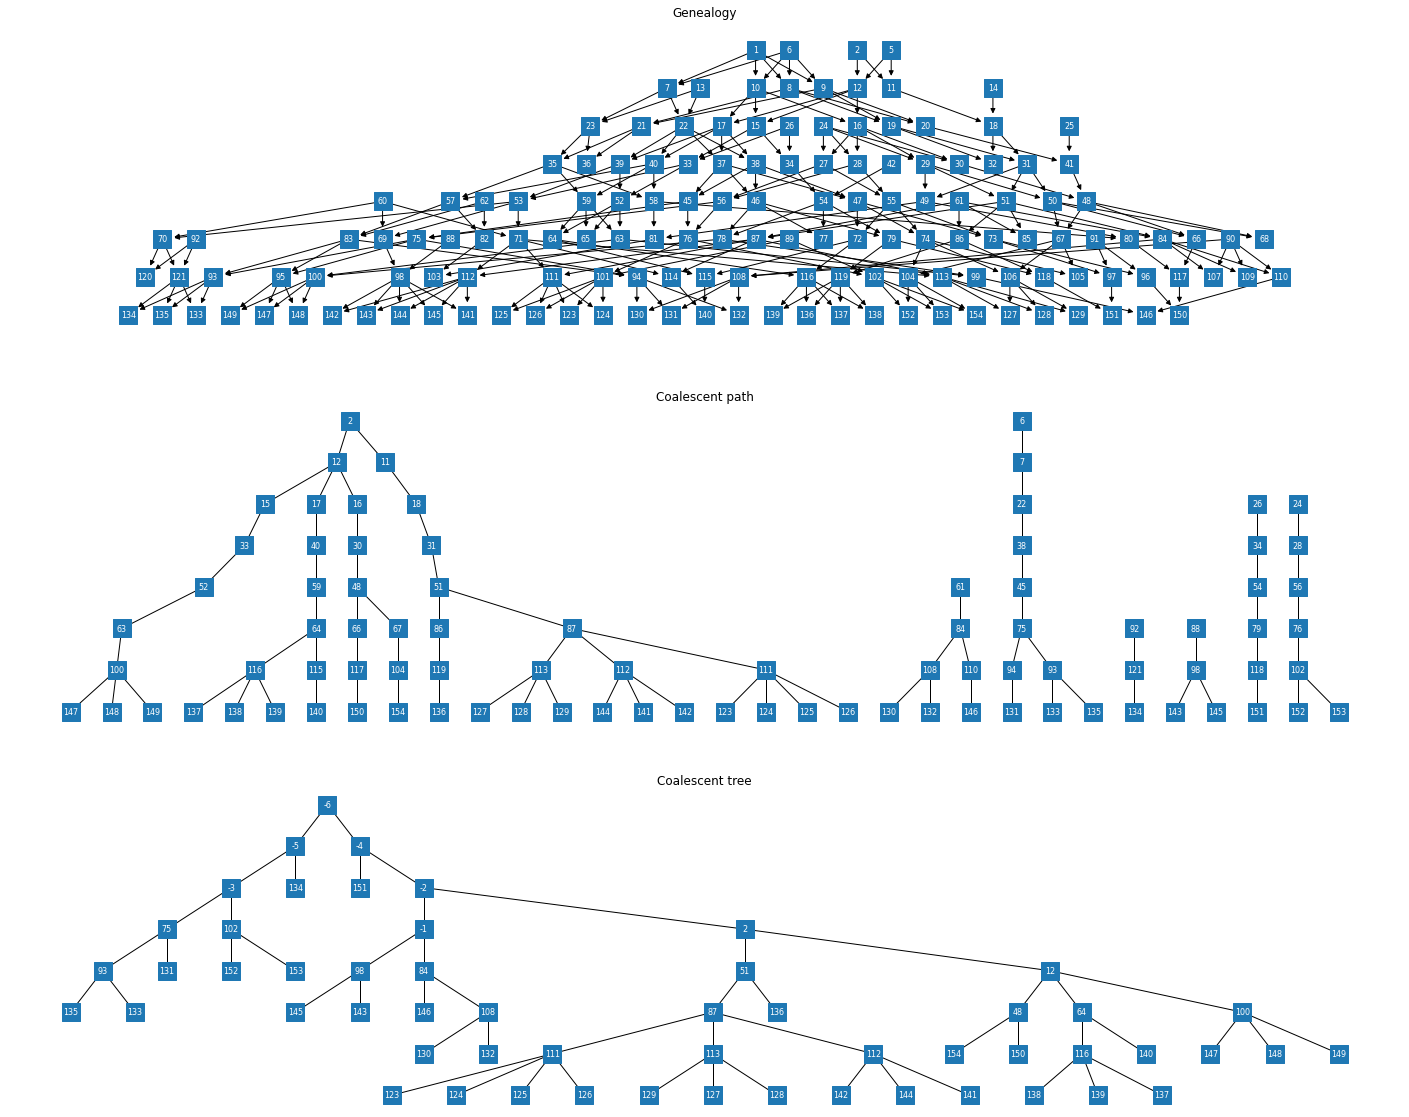

In [2]:
np.random.seed(724)

families = 5
generations = 7
avg_children = 2.2

gg = Pedigree.simulate_from_founders(families, generations, avg_children)

pt = gg.sample_path()
ct = pt.to_coalescent_tree()

fig, ax = plt.subplots(nrows=3, figsize=(25, 20))

gg.draw(ax=ax[0])
ax[0].set_title('Genealogy')
pt.draw(ax=ax[1])
ax[1].set_title('Coalescent path')
ct.draw(ax=ax[2])
ax[2].set_title('Coalescent tree')

In [3]:
algn = DescMatchingAligner(gg, ct)
algn.align()
algn.evaluate()

{'accuracy': 0.10204081632653061}

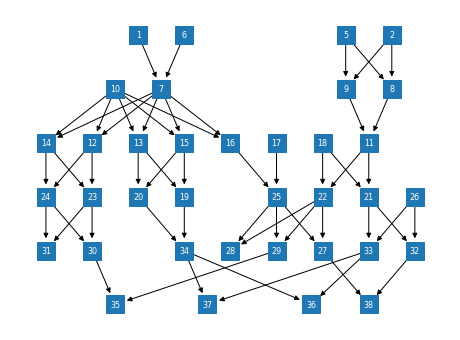

In [2]:
ped = Pedigree.simulate_from_founders(5, 5)

fig, ax = plt.subplots(figsize=(8, 6))

ped.draw(ax=ax)
plt.show()

sim = ped.generate_msprime_simulations()

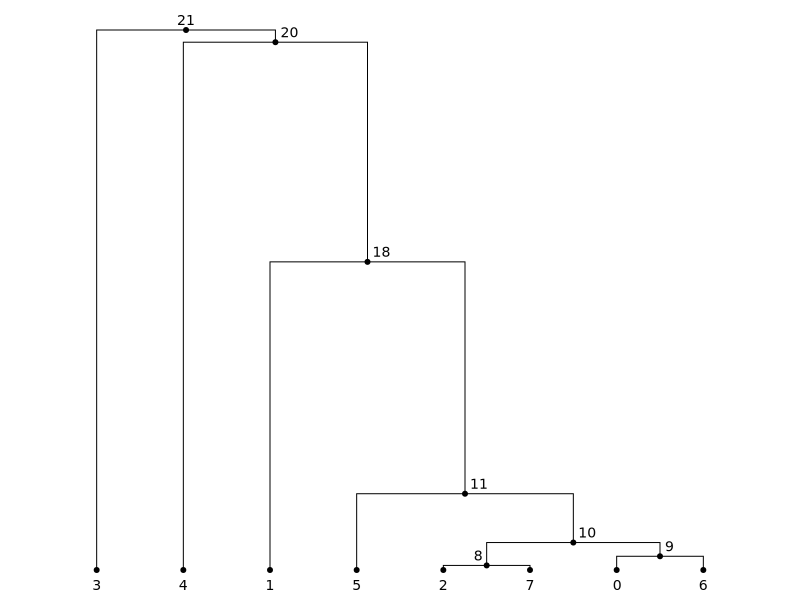

In [3]:
display(SVG(sim.first().draw(width=max(800, 2*len(ped.probands())), height=max(600, 2*len(ped.probands())))))

In [4]:
len(ped.probands())

4